# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Приветствую! Меня зовут Антон. И я совсем не против на "ты". Честно говоря, я сам не в восторге от результатов своей работы, не удалось агрегировать код для красивых функций и тп. Работа получилась в "процедурном" стиле. Но в целом, результат достигнут.
Заранее спасибо за проверку! Также буду благодарен за лайфаки, советы, истории из своего опыта(-это очень интересно!).

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgbm


In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    print('Ошибка чтения файла')

In [3]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
323743,2016-03-05 20:59:19,1600,wagon,1996,manual,39,other,60000,11,petrol,trabant,no,2016-03-05 00:00:00,0,96181,2016-03-21 04:17:54
210966,2016-03-13 10:41:22,14999,NaN,2005,NaN,220,c_klasse,150000,2,NaN,mercedes_benz,NaN,2016-03-13 00:00:00,0,42327,2016-03-13 10:41:22
148373,2016-03-12 23:55:29,9999,coupe,1973,manual,50,kaefer,150000,10,petrol,volkswagen,NaN,2016-03-12 00:00:00,0,59494,2016-03-13 03:51:57
284325,2016-03-11 09:25:18,6999,small,2012,manual,69,corsa,50000,12,petrol,opel,no,2016-03-11 00:00:00,0,55124,2016-03-12 21:10:52
223983,2016-04-01 00:52:25,10850,wagon,2010,manual,140,passat,150000,11,gasoline,volkswagen,no,2016-03-31 00:00:00,0,66882,2016-04-05 01:18:15


In [4]:
#глянем на правую границу дат размещения 
pd.to_datetime(df['DateCrawled']).max()


Timestamp('2016-04-07 14:36:58')

Удалим несущественные признаки.

In [5]:
#df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen'])
unused_cols =  ['DateCrawled', 'RegistrationMonth', 'DateCreated', 
                 'NumberOfPictures', 'PostalCode', 'LastSeen']
df = df.drop(columns = unused_cols)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
df.isna().sum().sort_values(ascending = False).head(7)

NotRepaired         71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
Price                   0
RegistrationYear        0
dtype: int64

В данных присутствуют как числовые так и строковые/категориальные данные. С последними будет отдельный разговор ниже :). Также имеем пропуски данных.

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Видны явные аномалии в следующих признаках : RegistrationYear, Power, RegistrationMonth, Price.
(Стоит заметить, что и без обработки аномальных значений модели выдают значение rmse ниже 2500)

In [9]:
anomal_cols = ['RegistrationYear', 'Power', 'Price']

Построим графики распределения аномальных признаков.

In [10]:
def get_boxplot_gr(anomal_cols):
    for anomal_col in anomal_cols:
        print('Распределение:', anomal_col)
        sns.boxplot(data = df[anomal_col])
        plt.show()

Распределение: RegistrationYear


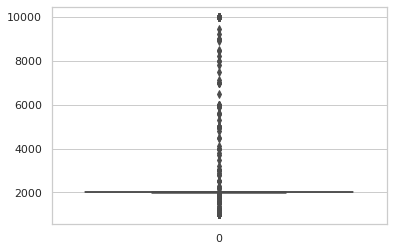

Распределение: Power


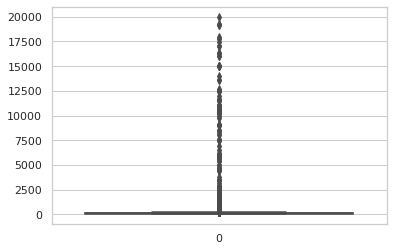

Распределение: Price


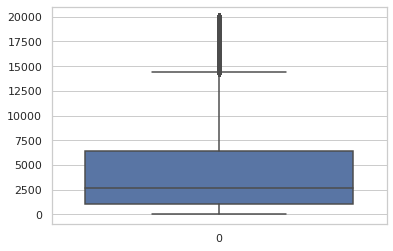

In [11]:
get_boxplot_gr(anomal_cols)

Посмотрим на пропуски

In [12]:
df.isna().sum().sort_values(ascending = False).head(6)

NotRepaired    71154
VehicleType    37490
FuelType       32895
Gearbox        19833
Model          19705
Price              0
dtype: int64

(Если забежать вперед, то ниже будет видно, что важность признаков FuelType, NotRepaired, Gearbox, VehicleType  менее 5%.
 Следовательно, пропуски в данных признаках логично заполнить, не боясь сильно исказить скрытые данные и предсказательную способность модели)
 Удалим аномальные значения:

In [13]:
df.loc[(df['Power']<20) | (df['Power']>1000), 'Power'] = np.nan # отсекаем аномальные мощности двигателя.
df.loc[(df['RegistrationYear']>=2016) | (df['RegistrationYear']<=1900), 'RegistrationYear'] = np.nan # отсекаем аномальные года

In [14]:
df.query("Price<100").shape

(13314, 10)

In [15]:
df.loc[(df['Price']<100), 'Price'] = np.nan # уберем аномальные цены слева

In [16]:
df['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [17]:
df['NotRepaired'].fillna('no', inplace=True)

In [18]:
#df['NotRepaired'] = np.where(df.Gearbox == 'yes' , 1, 0) # переведем признак в номинальный (бинарный)

In [19]:
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Признаки, которые имеют значительное количество категорий или не имеют явное преобладание одного из значений, заполним значением 'unknown'

In [20]:
df['VehicleType'].fillna('unknown', inplace=True)

In [21]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [22]:
df['FuelType'].fillna('unknown', inplace=True)

In [23]:
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [49]:
df['Gearbox'].fillna('unknown', inplace=True) # заполним пропуски другим значением
#df['Gearbox'] = np.where(df.Gearbox == 'manual' , 1, 0) # переведем признак в номинальный (бинарный) # 

В результате пробного обучения, модели показали чуть худшие показатели, когда категориальные признаки преобразуем в номинальные.В результате было решено категориальные признаки не трогать.

In [25]:
df.isna().sum().sort_values(ascending = False)

Power               40944
RegistrationYear    24195
Model               19705
Price               13314
VehicleType             0
Gearbox                 0
Kilometer               0
FuelType                0
Brand                   0
NotRepaired             0
dtype: int64

Оставшиеся признака с пропусками явлюятся весомыми для моделей, поэтому, чтобы не вносить искажения в данные, удалим их.

In [ ]:
df = df.dropna()

In [27]:
df.shape

(278673, 10)

In [28]:
df = df.astype({"VehicleType":  'category',
                "Model":'category',
                "FuelType":'category',
                "Brand":'category',
                "NotRepaired":'category',
                "Gearbox":'category',
                #"PostalCode":'category'})
                })


In [29]:
num_cols = df._get_numeric_data().columns
cat_col = list(df.select_dtypes(include=['category']).dtypes.index.values)
num_cols


Index(['Price', 'RegistrationYear', 'Power', 'Kilometer'], dtype='object')

## Обучение моделей

<b>Обучим модели catboost, lightbgm, RandomForestRegressor, LinearRegressor.

Разделяем выборку:

In [31]:
X = df.drop(columns=['Price'])
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
df.query("Price==0")
df = df.drop(index=df.query("Price==0").index)
df = df.drop(index=df.query("Power==0").index)

In [32]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
54594,suv,2003.0,manual,140.0,x_trail,150000,petrol,nissan,no
5542,bus,2004.0,manual,101.0,transit,150000,gasoline,ford,no
26900,bus,2000.0,manual,116.0,sharan,150000,gasoline,volkswagen,yes
30145,sedan,1996.0,manual,95.0,c_klasse,150000,gasoline,mercedes_benz,no
159661,sedan,2002.0,manual,124.0,vectra,40000,unknown,opel,no


In [33]:
%%time
# catboost
catboost_model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_col)

params = {'depth': [10, 20, 40],
          'learning_rate' : [0.3,  0.5, 0.7],
         #'l2_leaf_reg': [5, 10],
         'iterations': [100]}

catboost_grid = catboost_model.grid_search(param_grid = params, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5046.3149799	test: 5018.7230479	best: 5018.7230479 (0)	total: 184ms	remaining: 18.2s
1:	learn: 3876.9810109	test: 3858.3088198	best: 3858.3088198 (1)	total: 326ms	remaining: 15.9s
2:	learn: 3141.0011355	test: 3132.9514005	best: 3132.9514005 (2)	total: 441ms	remaining: 14.3s
3:	learn: 2667.0778065	test: 2669.9379961	best: 2669.9379961 (3)	total: 577ms	remaining: 13.9s
4:	learn: 2378.9029759	test: 2390.1149536	best: 2390.1149536 (4)	total: 728ms	remaining: 13.8s
5:	learn: 2160.3988988	test: 2174.9011576	best: 2174.9011576 (5)	total: 869ms	remaining: 13.6s
6:	learn: 2026.8822988	test: 2043.5265941	best: 2043.5265941 (6)	total: 1.01s	remaining: 13.5s
7:	learn: 1926.9156533	test: 1946.5314456	best: 1946.5314456 (7)	total: 1.12s	remaining: 12.9s
8:	learn: 1864.5650831	test: 1886.5990274	best: 1886.5990274 (8)	total: 1.24s	remaining: 12.5s
9:	learn: 1824.7117877	test: 1849.5391397	best: 1849.5391397 (9)	total: 1.35s	remaining: 12.1s
10:	learn: 1799.4700668	test: 1827.6379999	best: 1

<b> Модель catboost

In [34]:
catboost_grid["params"]

{'depth': 10, 'iterations': 100, 'learning_rate': 0.3}

In [35]:
mse(y_test, catboost_model.predict(X_test), squared=False)

1538.2748718859962

<AxesSubplot:>

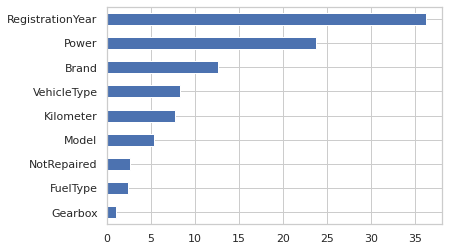

In [36]:
feat_imp = pd.Series(catboost_model.feature_importances_, X_train.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

In [37]:
# %%time

# lgbm_model = lgbm.LGBMRegressor(boosting_type='gbdt',
#                                n_estimators=100,
#                               categorical_feature=cat_col,
#                               learning_rate=0.4,
#                               objective='mse',
#                               n_jobs=-1, random_state=0)

# params = {"max_depth": [10, 100],
#               "learning_rate" : [0.01,0.1,0.5],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [100]
#              }

# gsearch = RandomizedSearchCV(estimator=lgbm_model, param_distributions=params, cv=3)
# lgb_model_gs = gsearch.fit(X=X_train, y=y_train)

# print(lgb_model_gs.best_params_, lgb_model.best_score_)

# обучение очень длительное, оказываемся от поисков гиперпараметров.

In [38]:
lgbm_model = lgbm.LGBMRegressor(boosting_type='gbdt',
                              max_depth=50,
                              n_estimators=100,
                              categorical_feature=cat_col,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

In [39]:
%%time
lgbm_model.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 6min 51s, sys: 6.34 s, total: 6min 57s
Wall time: 6min 59s


LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'NotRepaired'],
              learning_rate=0.4, max_depth=50, objective='mse', random_state=0)

In [40]:
mse(y_test, lgbm_model.predict(X_test), squared=False)

1521.579003757714

<AxesSubplot:>

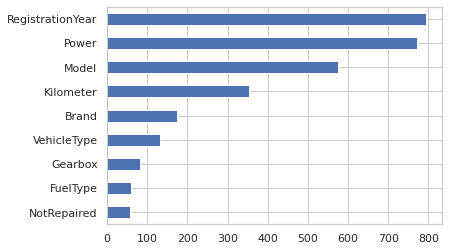

In [42]:
feat_imp = pd.Series(lgbm_model.feature_importances_, X_train.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

Попробуем модели случайного леса и линейную регрессию, будем использовать числовые признаки.

In [43]:
df1 = df[num_cols]
X = df1.drop(columns=['Price'])
y = df1['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [46]:
param_grid = { 
    'n_estimators': [20, 50, 100],
    'max_depth': [10, 30]
}

gs_rf_clf = GridSearchCV(RandomForestRegressor(), param_grid, cv=4, n_jobs=-1)

In [47]:
%%time
gs_rf_clf.fit(X_train, y_train)
mse(y_test, gs_rf_clf.predict(X_test), squared=False)

CPU times: user 2min 22s, sys: 1.16 s, total: 2min 23s
Wall time: 2min 23s


2031.7893580501418

In [48]:
%%time
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
mse(y_test, lr_clf.predict(X_test), squared=False)

CPU times: user 37.6 ms, sys: 12.1 ms, total: 49.8 ms
Wall time: 39.9 ms


3048.7128249912234

## Анализ моделей

Резюмируем результаты обучения моделей с выбранными гиперпараметрами:
1. catboost: время обучения: 1min 16s, rmse на тестовой выборке: 1538
2. lightbgm: время обучения: 6min 57s, rmse на тестовой выборке: 1521
3. random forest: время обучения: 2min 23s, rmse на тестовой выборке: 2031
4. linear regression: время обучения: 49.8 ms, rmse на тестовой выборке: 3048

Первые три модели удовлетворяют требованиям проекта: rmse < 2500.
Скорость предсказания после обучения у всех моделей высокая, поэтому акцентировать внимание на этом не будем.
Наилучший показатель rmse показала модель lightbgm, но время обучения сравнительно с остальными - очень велико.
Линейная регрессия, максимальна быстрая, но предсказательная способность очень низкая.
Резюмируя, можно сделать рекомендацию гипотетическому заказчику использовать модель catboost, которая по точности сравнима с lightbgm, но обучается в 6 раз быстрее и вероятнее всего, с более тонкой настройкой гиперпараметров, модель бы показала более точные результаты.